In [63]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from CNN2D_velocities import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time
import os
import pickle

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

## TRAIN SET

In [64]:
gt_train_coord = pickle.load( open( "./import_dataset_2/train/gt_train_coord.pkl", "rb" ) )
gt_train  = pickle.load( open( "./import_dataset_2/train/gt_train.pkl", "rb" ) )
in_train_coord  = pickle.load( open( "./import_dataset_2/train/in_train_coord.pkl", "rb" ) )
inputs_train = pickle.load( open( "./import_dataset_2/train/inputs_train.pkl", "rb" ) )

inputs_train = inputs_train[:,:,2:]
gt_train = gt_train[:,:,2:]


inputs_train = torch.from_numpy(inputs_train).float()
gt_train = torch.from_numpy(gt_train).float()

gt_train = gt_train.unsqueeze(1) # add 1 dimension to the training set
inputs_train = inputs_train.unsqueeze(1) # add 1 dimension to the training set

inputs_train.shape,gt_train.shape

(torch.Size([5157, 1, 10, 162]), torch.Size([5157, 1, 11, 2]))

## VALIDATION SET

In [65]:
gt_validation_coord = pickle.load( open( "./import_dataset_2/validation/gt_validation_coord.pkl", "rb" ) )
gt_validation = pickle.load( open( "./import_dataset_2/validation/gt_validation.pkl", "rb" ) )
in_validation_coord = pickle.load( open( "./import_dataset_2/validation/in_validation_coord.pkl", "rb" ) )
inputs_validation = pickle.load( open( "./import_dataset_2/validation/inputs_validation.pkl", "rb" ) )

inputs_validation = inputs_validation[:,:,2:]
gt_validation = gt_validation[:,:,2:]

inputs_validation = torch.from_numpy(inputs_validation).float()
gt_validation = torch.from_numpy(gt_validation).float()

gt_validation = gt_validation.unsqueeze(1) # add 1 dimension to the training set
inputs_validation = inputs_validation.unsqueeze(1) # add 1 dimension to the training set
print (inputs_validation.shape)

gt_validation_coord.shape,gt_validation.shape,in_validation_coord.shape,inputs_validation.shape

torch.Size([1719, 1, 10, 162])


((11, 1719, 2),
 torch.Size([1719, 1, 11, 2]),
 (10, 1719, 2),
 torch.Size([1719, 1, 10, 162]))

## TEST SET

In [77]:
gt_test_coord_1 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_1.pkl", "rb" ) )
gt_test_1 = pickle.load( open( "./import_dataset_2/test/gt_test_1.pkl", "rb" ) )
in_test_coord_1 = pickle.load( open( "./import_dataset_2/test/in_test_coord_1.pkl", "rb" ) )
inputs_test_1 = pickle.load( open( "./import_dataset_2/test/inputs_test_1.pkl", "rb" ) )

gt_test_coord_2 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_2.pkl", "rb" ) )
gt_test_2 = pickle.load( open( "./import_dataset_2/test/gt_test_2.pkl", "rb" ) )
in_test_coord_2 = pickle.load( open( "./import_dataset_2/test/in_test_coord_2.pkl", "rb" ) )
inputs_test_2 = pickle.load( open( "./import_dataset_2/test/inputs_test_2.pkl", "rb" ) )

gt_test_coord_3 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_3.pkl", "rb" ) )
gt_test_3 = pickle.load( open( "./import_dataset_2/test/gt_test_3.pkl", "rb" ) )
in_test_coord_3 = pickle.load( open( "./import_dataset_2/test/in_test_coord_3.pkl", "rb" ) )
inputs_test_3 = pickle.load( open( "./import_dataset_2/test/inputs_test_3.pkl", "rb" ) )

inputs_test_1 = inputs_test_1[:,:,2:]
gt_test_1 = gt_test_1[:,:,2:]
inputs_test_2 = inputs_test_2[:,:,2:]
gt_test_2 = gt_test_2[:,:,2:]
inputs_test_3 = inputs_test_3[:,:,2:]
gt_test_3 = gt_test_3[:,:,2:]

inputs_test_1 = torch.from_numpy(inputs_test_1).float()
gt_test_1 = torch.from_numpy(gt_test_1).float()
inputs_test_1 = inputs_test_1.unsqueeze(1) 

inputs_test_2 = torch.from_numpy(inputs_test_2).float()
gt_test_2 = torch.from_numpy(gt_test_2).float()
inputs_test_2 = inputs_test_2.unsqueeze(1)

inputs_test_3 = torch.from_numpy(inputs_test_3).float()
gt_test_3 = torch.from_numpy(gt_test_3).float()
inputs_test_3 = inputs_test_3.unsqueeze(1)

### Model

In [67]:
net = CNN2D_velocities()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)

traindataset = utils.TensorDataset(inputs_train, gt_train[:,:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=16, shuffle=True)

valdataset = utils.TensorDataset(inputs_validation, gt_validation[:,:,1:,:])
valloader = utils.DataLoader(valdataset, batch_size=16, shuffle=True)

In [81]:
epochs = 50
steps = 0
running_loss = 0
print_every = 323
loss_train = []
loss_val = []

for e in range(epochs):
    start = time.time()
    steps_bis = 0
    total_train_loss=0
    for train_coord, ground_tru in iter(trainloader):
        
        steps += 1
        steps_bis += 1
        
        input_train = Variable(train_coord)
        in_train = input_train.squeeze(1)
        target = Variable(ground_tru)
        targets = target.squeeze(1)
        optimizer.zero_grad()
        out = net.forward(input_train)
        out = out.reshape(out.shape[0],10,2)
        loss1 = (criterion(out[:,:,0:2], targets[:,:,0:2]))
        
        loss1.backward(retain_graph=True)
        optimizer.step()
        
        running_loss += (loss1).item()
        total_train_loss += (loss1).item()
        
        if steps % print_every == 0:
            stop = time.time()
            val_loss=0
            
            for ii, (images, labels) in enumerate(valloader):
                
                inp = Variable(images)
                input_val = inp.squeeze(1)
                lab = Variable(labels)
                valgt = lab.squeeze(1)
                predicted = net.predict(inp)
                predicted = predicted.reshape(predicted.shape[0],10,2)
                val_loss+= (criterion(predicted[:,:,0:2],valgt[:,:,0:2]).item())
                
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Validation Loss: {:.4f}..".format(val_loss/ii),
                  "Training Loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                 )
            loss_val.append(val_loss/ii)
            running_loss = 0
            start = time.time()
    loss_train.append(total_train_loss/steps_bis)

Epoch: 1/50.. Validation Loss: 0.1201.. Training Loss: 0.1081.. 0.0120 s/batch 
Epoch: 2/50.. Validation Loss: 0.1171.. Training Loss: 0.1051.. 0.0111 s/batch 
Epoch: 3/50.. Validation Loss: 0.1178.. Training Loss: 0.1019.. 0.0100 s/batch 
Epoch: 4/50.. Validation Loss: 0.1184.. Training Loss: 0.0992.. 0.0090 s/batch 
Epoch: 5/50.. Validation Loss: 0.1132.. Training Loss: 0.0963.. 0.0096 s/batch 
Epoch: 6/50.. Validation Loss: 0.1113.. Training Loss: 0.0936.. 0.0106 s/batch 
Epoch: 7/50.. Validation Loss: 0.1131.. Training Loss: 0.0914.. 0.0123 s/batch 
Epoch: 8/50.. Validation Loss: 0.1084.. Training Loss: 0.0884.. 0.0099 s/batch 
Epoch: 9/50.. Validation Loss: 0.1065.. Training Loss: 0.0862.. 0.0097 s/batch 
Epoch: 10/50.. Validation Loss: 0.1098.. Training Loss: 0.0842.. 0.0096 s/batch 
Epoch: 11/50.. Validation Loss: 0.1053.. Training Loss: 0.0819.. 0.0108 s/batch 
Epoch: 12/50.. Validation Loss: 0.1057.. Training Loss: 0.0802.. 0.0114 s/batch 
Epoch: 13/50.. Validation Loss: 0.102

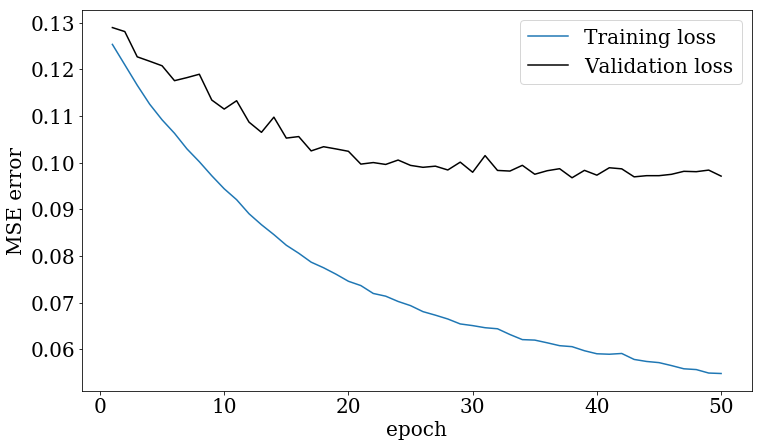

In [62]:
epoch = np.arange(1,epochs+1)
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

plt.plot(epoch,loss_train,label='Training loss')
plt.plot(epoch,loss_val,c='k',label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE error')
plt.legend()
#plt.savefig(r'./figures/loss_coord.pdf', bbox_inches='tight')

In [80]:
output_test_1 = net.predict(inputs_test_1)
output_test_1 = output_test_1.data.numpy()
output_test_1 = np.reshape(output_test_1,(250,10,2))

output_test_2 = net.predict(inputs_test_2)
output_test_2 = output_test_2.data.numpy()
output_test_2 = np.reshape(output_test_2,(1006,10,2))

output_test_3 = net.predict(inputs_test_3)
output_test_3 = output_test_3.data.numpy()
output_test_3 = np.reshape(output_test_3,(460,10,2))

## Post processing step
Go back to coordinate:
We have Vx and Vy and we want x and y.
$ V = d/t$
$ d = V*t$
Here t = 0.4s between each point.
Start from data at index 9. Then we add d_x and d_y to the last x and y.

##### Type 1 trajectory

In [82]:
output_coord_1=np.zeros([11,inputs_test_1.shape[2],2])
for j in range(11):
    for i in range(output_test_1.shape[2]):
        if j==0:
            output_coord_1[j,i,0:2] = in_test_coord_1[9,i,0:2]
        else:
            output_coord_1[j,i,0:2] = output_coord_1[j-1,i,0:2]+output_test_1[i,j-1,:]*0.4
        

In [83]:
dist = np.zeros(inputs_test_1.shape[2])
for i in range(inputs_test_1.shape[2]):
    dist[i] = np.sqrt(sum((gt_test_coord_1[10,i,:]-output_coord_1[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 0.59


In [84]:
avr = np.zeros((inputs_test_1.shape[2],11))
for i in range(inputs_test_1.shape[2]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_1[j,i,:]-output_coord_1[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 0.478


(-0.13013364720810205,
 0.5328065913701431,
 -0.1556913728117943,
 3.26951882904768)

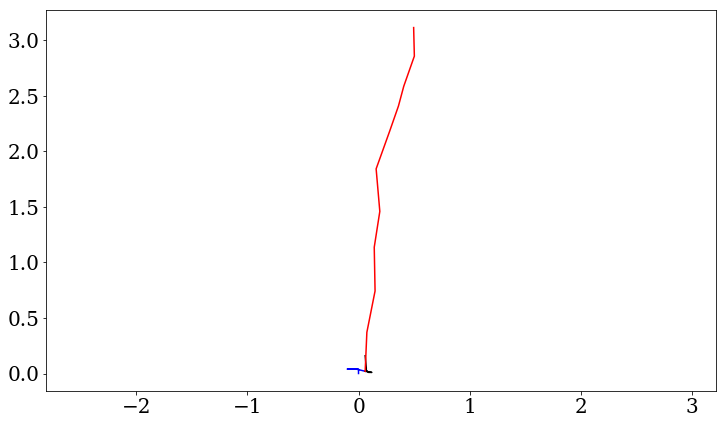

In [85]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_1.shape[1])

plt.plot(in_test_coord_1[:,ind,0],in_test_coord_1[:,ind,1],c='b')
plt.plot(gt_test_coord_1[:,ind,0],gt_test_coord_1[:,ind,1],c='k')
plt.plot(output_coord_1[:,ind,0],output_coord_1[:,ind,1],c='r')
plt.axis('equal')

##### Type 2 trajectory

In [86]:
output_coord_2=np.zeros([11,inputs_test_2.shape[2],2])
for j in range(11):
    for i in range(output_test_2.shape[2]):
        if j==0:
            output_coord_2[j,i,0:2] = in_test_coord_2[9,i,0:2]
        else:
            output_coord_2[j,i,0:2] = output_coord_2[j-1,i,0:2]+output_test_2[i,j-1,:]*0.4
        

In [87]:
dist = np.zeros(inputs_test_2.shape[2])
for i in range(inputs_test_2.shape[2]):
    dist[i] = np.sqrt(sum((gt_test_coord_2[10,i,:]-output_coord_2[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 7.029


In [88]:
avr = np.zeros((inputs_test_2.shape[1],11))
for i in range(inputs_test_2.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_2[j,i,:]-output_coord_2[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 2.477


(-0.10698990650000001, 2.2467880365, -0.5169107140000001, 10.855124994)

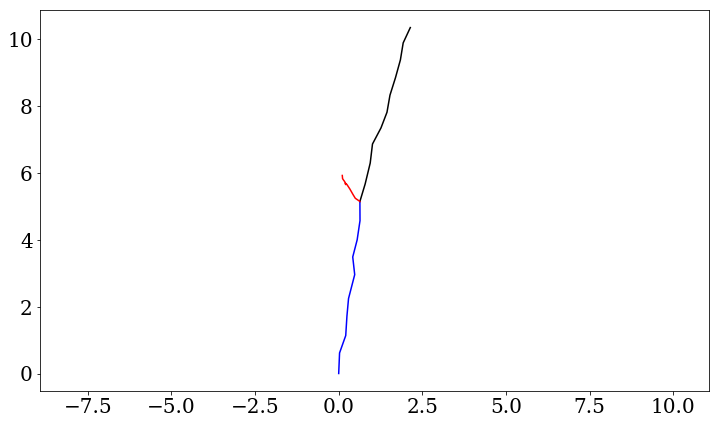

In [89]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_2.shape[1])

plt.plot(in_test_coord_2[:,ind,0],in_test_coord_2[:,ind,1],c='b')
plt.plot(gt_test_coord_2[:,ind,0],gt_test_coord_2[:,ind,1],c='k')
plt.plot(output_coord_2[:,ind,0],output_coord_2[:,ind,1],c='r')
plt.axis('equal')

##### Type 3 trajectory

In [90]:
output_coord_3=np.zeros([11,inputs_test_3.shape[2],2])
for j in range(11):
    for i in range(inputs_test_3.shape[2]):
        if j==0:
            output_coord_3[j,i,0:2] = in_test_coord_3[9,i,0:2]
        else:
            output_coord_3[j,i,0:2] = output_coord_3[j-1,i,0:2]+output_test_3[i,j-1,:]*0.4
        

In [91]:
dist = np.zeros(output_test_3.shape[2])
for i in range(output_test_3.shape[2]):
    dist[i] = np.sqrt(sum((gt_test_coord_3[10,i,:]-output_coord_3[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 2.581


In [92]:
avr = np.zeros((inputs_test_3.shape[1],11))
for i in range(inputs_test_3.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_3[j,i,:]-output_coord_3[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 1.201


(-0.7562638115696971,
 0.23814964296363997,
 -0.27478025779823306,
 5.770385413762894)

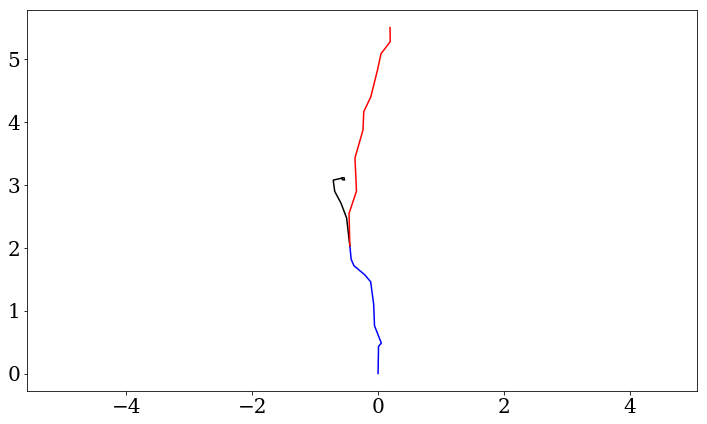

In [93]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_3.shape[0])

plt.plot(in_test_coord_3[:,ind,0],in_test_coord_3[:,ind,1],c='b')
plt.plot(gt_test_coord_3[:,ind,0],gt_test_coord_3[:,ind,1],c='k')
plt.plot(output_coord_3[:,ind,0],output_coord_3[:,ind,1],c='r')
plt.axis('equal')

In [94]:
torch.save(net.state_dict(), 'speed_2CNN.pt')